# Building cancer-detection system with RadIO

In this notebook we are going to use data from the [LUNA Challenge](https://luna16.grand-challenge.org/Home/)

In [1]:
PATH_TO_FOLDER = '/home/alexander/Work/Notebooks/Old/PyData' # your local path to folder where the downloaded data folder lies

In [2]:
import os
assert 'data' in os.listdir(PATH_TO_FOLDER)
import sys
sys.path.append('..')

## 1. CT-scans and Lung-cancer

In [3]:
# some imports
import numpy as np
from ipywidgets import interact
from utils import pil_plot_slices, load_example, show_slices, get_pixel_coords, show_images

import radio
from radio.batchflow import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB

* CT-scans are 3d-arrays of data. Cancer in lungs is represented in *pulmonary nodules*:

In [4]:
# plot a scan and a corresponding mask
PATH_TO_SAMPLE = os.path.join(PATH_TO_FOLDER, 'data/scans_sample/')

bch = load_example(PATH_TO_SAMPLE, radio)
interact(lambda height: pil_plot_slices(height, bch.get(0, 'images'), bch.get(0, 'masks')),
         height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>

## 3. Building detection system-workflow

### `Dataset`, `Pipeline` and `Batch`-class on `MNIST`

CT-scans are voluminous. It is not possible to store all scans from the dataset in memory at once. In order to work with such datasets we use
* `Dataset` and `Batch`-classes which capture **indexing structure and the logic** of data-processing
* `Pipeline`s which represent **sequences** of data-processing actions

Let us set up these structures for `MNIST`-dataset.

In [5]:
PATH_TO_MNIST = os.path.join(PATH_TO_FOLDER, 'data/mnist_subset/*blk')

preparing *index*, a structure that indexes files on disk (or somewhere else):

In [6]:
mnistindex = FilesIndex(path=PATH_TO_MNIST, no_ext=True)
# that is, we need all files with .blk extension in a certan directory

In [7]:
mnistindex.indices[:5]

array(['35668', '41810', '16776', '9106', '10122'], dtype='<U69')

The logic of data-processing is implemented in `Batch`-classes. We use `ImageBatch` for `MNIST`:

In [8]:
from radio.batchflow import ImagesBatch

When combining `Batch`-class and `Index` you get `Dataset`:

In [9]:
mnistset = Dataset(index=mnistindex, batch_class=ImagesBatch)

before starting any computations you need a plan - `pipeline`. `pipeline` is a sequence of `actions` from the `Batch`-class you use:

In [10]:
# nothing is computed here!! it's only a plan
pipeline = (Pipeline()
            .load(fmt='blosc', components=['images', 'labels'])  # load data from disk
            .sp_resize((23, 23)))                                # perform resize of mnist pics from (28, 28) to (23, 23)

real computation starts when you pass a part of your `Dataset`, a `Batch`, through the workflow:

In [11]:
bch = (mnistset >> pipeline).next_batch(batch_size=3)

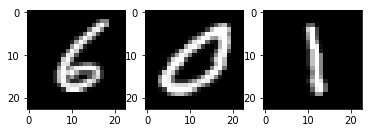

In [12]:
show_images(bch)

### 3.1 Preprocessing

### It's your turn now!
Let's get back to CT-scans and cancer now! In this section you need to assemble a small pipeline, that `load`s scans from disk and `resize`s them.

(We will help you, of course)

* Set up the index

In [13]:
path_to_scans_sample = os.path.join(PATH_TO_FOLDER, 'data/sample_raw/*.mhd')
luna_index = FilesIndex(path=path_to_scans_sample, no_ext=True)

In [14]:
luna_index.indices

array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998'],
      dtype='<U126')

The logic of data-processing in `RadIO` is implemented in `CTImagesMaskedBatch`-class, or `CTIMB`:

In [15]:
from radio import CTImagesMaskedBatch as CTIMB

* Use `CTIMB` and created index to set up a `Dataset` of scans:

In [16]:
lunaset = Dataset(index=luna_index, batch_class=CTIMB)

to make sure that everything is OK, run this cell:

In [17]:
lunaset.indices[0]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998'

You need to load scans from format (`fmt`-arg) `raw` and `resize` them to `shape=(256, 384, 384)`. Note that you need `components=['images', 'spacing', 'origin']`

First, set up the plan of actions:

In [18]:
preprocessing = (Pipeline()
                 .load(fmt='raw', components=['images', 'spacing', 'origin'])
                 .resize(shape=(256, 384, 384)))

Now, run the computations by passing a part of `lunaset` through your `pipeline`:

In [19]:
# you need to get one item! So, batch_size=1 
batch = (lunaset >> preprocessing).next_batch(1)

check out the results:

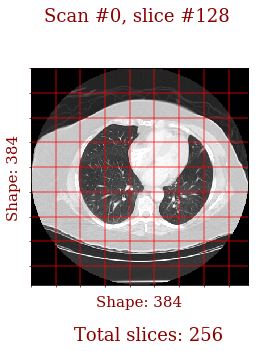

In [20]:
show_slices(batch, scan_indices=[0], ns_slice=[128], grid=True, clims=(-1200, 200))

### Going on with `preprocessing`

Luna-dataset provides cancer-annotations for targets:

In [21]:
ANNO_PATH = os.path.join(PATH_TO_FOLDER, 'data/annotations.csv')

In [22]:
import pandas as pd
nodules_df = pd.read_csv(ANNO_PATH)
nodules_df.head(2)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708


Make use of it!

In [23]:
preprocessing += (Pipeline()
                  .fetch_nodules_info(nodules_df)
                  .create_mask()
                  .normalize_hu())

Also we normalize data-range to [0, 255]

Perhaps you need to `dump` preprocessed scans and get back to them later?

In [24]:
dumping = (Pipeline()
           .dump(fmt='blosc', dst=os.path.join(PATH_TO_FOLDER, 'data/dump_dir/'),
                 components=['images', 'masks', 'spacing', 'origin'], i8_encoding_mode='linear'))

In [25]:
# batch = (lunaset >> (preprocessing + dumping)).next_batch(1)

In [26]:
batch = (lunaset >> preprocessing).next_batch(1)

check out the results:

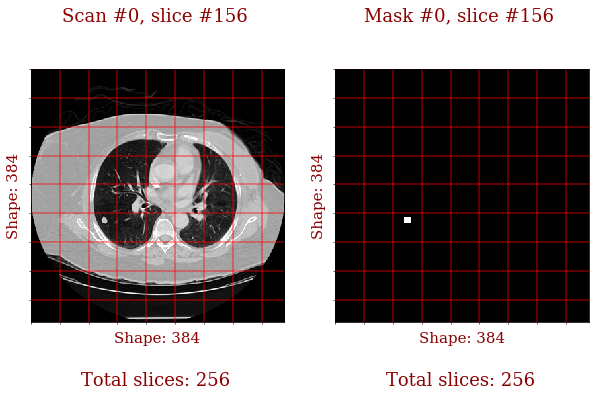

In [27]:
show_slices(batch, scan_indices=[0, 0], ns_slice=[156, 156], grid=True, clims=[(0, 255), (0, 1)],
            components=['images', 'masks'])

Now let's have a look at two scans:

In [28]:
two_scans_dataset = Dataset(index=FilesIndex(path=os.path.join(PATH_TO_FOLDER, 'data/raw_blosc/*'), sort=True,
                            dirs=True), batch_class=CTIMB)

preprocessing_raw = Pipeline().load(fmt='blosc', components=['images', 'spacing', 'origin'])
batch = (two_scans_dataset >> preprocessing_raw).next_batch(2, shuffle=False)

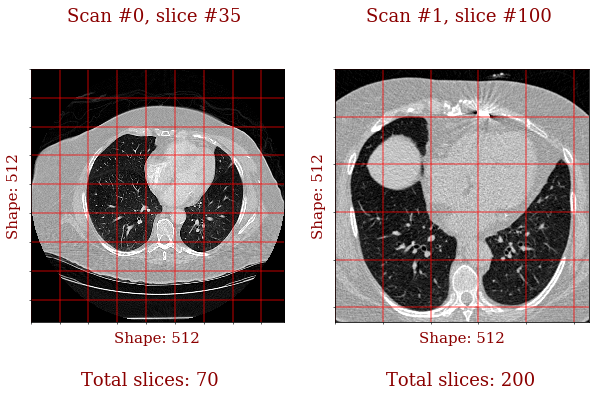

In [29]:
show_slices(batch, scan_indices=[0, 1], ns_slice=list(batch.images_shape[:, 0] // 2), grid=True, clims=(0, 255))

One can see that the lungs are larger on the left scan. This can be explained by a big difference in scale (represented by a grid). This can be a source of uncontrollable variation in the training dataset. In order to make scans more isotropic, we add action `unify_spacing` to our preprocessing workflow.

In [30]:
SHAPE = (100, 256, 256)
SPACING = (1.7, 1., 1.)

In [31]:
preprocessing_raw += (Pipeline()
                      .unify_spacing(spacing=SPACING, shape=SHAPE, padding='constant'))

Now pass a batch through the workflow and see the difference:

In [32]:
batch = (two_scans_dataset >> preprocessing_raw).next_batch(2, shuffle=False)

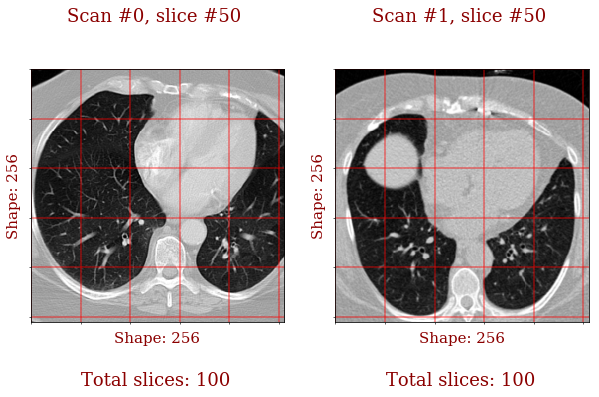

In [33]:
show_slices(batch, scan_indices=[0, 1], ns_slice=list(batch.images_shape[:, 0] // 2), grid=True, clims=(0, 255))

### 3.2 Augmentation

In [34]:
LUNA_BLOSC = os.path.join(PATH_TO_FOLDER, 'data/scans_sample/*')
luna_blosc = Dataset(FilesIndex(path=LUNA_BLOSC, dirs=True), batch_class=CTIMB)

Let us add some augmentation actions to the workflow. To begin with, let's *controllably* introduce variation into the scale by randomly zooming in/zooming out on scans:

In [35]:
spacing_options = [(1.7, 0.8, 0.8), (1.7, 1.0, 1.0), (1.7, 1.2, 1.2), (1.7, 1.4, 1.4)]

here we define spacing randomizer, a function that randomly fetches spacing:

In [36]:
spacing_randomizer = lambda *args: spacing_options[np.random.choice(range(len(spacing_options)))]

In [37]:
preprocessing = (Pipeline()
                 .load(fmt='blosc', components=['images', 'spacing', 'origin', 'masks'])
                 .fetch_nodules_from_mask()
                )

In [38]:
from radio.batchflow import F
augmentation = (Pipeline()
                 .rotate(random=True, angle=10, components=['images', 'masks'])
                 .unify_spacing(spacing=F(spacing_randomizer), shape=(128, 256, 256), padding='constant'))

add some rotation:

In [39]:
batch = (luna_blosc >> (preprocessing + augmentation)).next_batch(1)

In [40]:
interact(lambda height: pil_plot_slices(height, batch.get(0, 'images'), batch.get(0, 'masks')),
         height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>

### MIPs: a way to reduce 3d-problem to a 2d-one

Approach of participants in `Kaggle-DsBowl` and `Luna-challenge`: train network on small crops as 1) modern **GPUs** are just not enough to store full scans and 2) it's a way of augmenting the dataset. This approach leads to inference that takes **a lot** of time. Our approach: add *Maximum Intensity Projection (MIP)* in preprocessing.

In [41]:
xips = batch.xip('images', mode='max', depth=7, stride=3)

In [42]:
lxip = int(len(xips) / len(batch))

In [43]:
interact(lambda height: pil_plot_slices(height, batch.get(0, 'images'), xips[0:lxip, :, :, 0],
                                        batch.get(0, 'masks')),
         height=(0, 0.99, 0.005))

interactive(children=(FloatSlider(value=0.495, description='height', max=0.99, step=0.005), Output()), _dom_cl…

<function __main__.<lambda>(height)>

### 3.3 Model training

Module `dataset` contains a zoo of neural network models written on `tensorflow` and (coming soon) `pytorch`. Firstly, choose a model from the zoo:

In [44]:
# more imports
import tensorflow as tf
from radio.batchflow import B, V, F
from radio.batchflow.models.tf import TFModel, UNet
from radio.batchflow.models.tf.losses import dice

The next step is configuring a model:

In [45]:
model_config = dict(
    inputs=dict(
        images=dict(shape=(256, 256, 1)),
        masks=dict(shape=(256, 256, 1), name='targets')
    ),
    initial_block=dict(inputs='images'),
    output=dict(ops='sigmoid'),
    loss=dice,
    optimizer='Adam')

In [46]:
# init model in pipeline, assemble training pipeline
XIP_PARAMS = dict(mode='max', depth=16, stride=12, channels=1)
model_training = (Pipeline()
                  .init_model('static', UNet, 'unet', model_config)
                  .train_model('unet', feed_dict=dict(images=F(CTIMB.xip, component='images', **XIP_PARAMS),
                                                      masks=F(CTIMB.xip, component='masks', **XIP_PARAMS))))

combining all parts into one workflow

In [47]:
workflow = (preprocessing + augmentation + model_training) << luna_blosc

training cycle

In [48]:
N_ITERS = 1
for i in range(N_ITERS):
    #workflow.next_batch(1)
    pass

### 3.4 Inference using pretrained model

In [49]:
LUNA_BLOSC = os.path.join(PATH_TO_FOLDER, 'data/scans_sample/*')
luna_blosc = Dataset(FilesIndex(path=LUNA_BLOSC, dirs=True), batch_class=CTIMB)

In [50]:
import tensorflow as tf
from radio.batchflow import B, V, F
from radio.batchflow.models.tf import TFModel

model_path = os.path.join(PATH_TO_FOLDER, 'data/unet/e_6_3c_unet/models/logloss/')
config = dict(load=dict(path=model_path),
              session=dict(config=tf.ConfigProto(allow_soft_placement=True)))

XIP_PARAMS = dict(mode='max', depth=6, stride=2, channels=3)

ppl_predict_scan = (Pipeline()
                    .init_model('static', TFModel, 'xipnet', config)
                    .load(fmt='blosc', components=['images', 'spacing', 'origin', 'masks'])
                    .fetch_nodules_from_mask()
                    .init_variables(['predictions', 'nodules_true', 'nodules_predicted'])
                    .fetch_nodules_from_mask()
                    .update_variable('nodules_true', B('nodules'))
                    .predict_model('xipnet', save_to=V('predictions'),
                                   feed_dict=dict(images=F(CTIMB.xip, component='images', **XIP_PARAMS)))
                    .call(CTIMB.unxip, xip=V('predictions'), squeeze=True, **XIP_PARAMS,
                          component='predictions')
                    .fetch_nodules_from_mask()
                    .update_variable('nodules_predicted', B('nodules')) << luna_blosc)

INFO:tensorflow:Restoring parameters from /home/alexander/Work/Notebooks/Old/PyData/data/unet/e_6_3c_unet/models/logloss/model-230000


In [51]:
btch = ppl_predict_scan.next_batch(1)

In [52]:
interact(lambda height: pil_plot_slices(height, btch.get(0, 'images'), btch.masks, 
                                        btch.predictions), height=(0, 0.99, 0.01))

interactive(children=(FloatSlider(value=0.49, description='height', max=0.99, step=0.01), Output()), _dom_clas…

<function __main__.<lambda>(height)>